# Stuff

In [ ]:
# similarity calculation
MORGAN_RADIUS=9
FINGERPRINT_BITS=4096

# analogue selection
GROUP_SIZE=10

In [ ]:
TEST_SLICE = 10  # set to -1 for full set

In [ ]:
import os
import pandas as pd
import numpy as np
import numba
from numba import prange
from tqdm.notebook import tqdm

from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdFingerprintGenerator, SmilesMolSupplier

from fingerprint_computation import FingerprintGenerator, compute_fingerprints_from_smiles
from ms_chemical_space_explorer.similarity_maps import generate_mol, get_similarity_map_weights, FingerprintFunction

df_file = os.path.join("data", "explorer_group_size", f"explorer_benchmark_size{GROUP_SIZE}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")

In [60]:
import sys
import os

# Get path to the parent directory containing the package
MAIN_FOLDER = os.path.abspath(
    os.path.join(os.getcwd(), "../ms_chemical_space_explorer")
)
DATA_FOLDER = "data"
PROCESSED_DATA_FOLDER = "processed"
FILENAME = "1000_test_spectra.mgf"
FILEPATH = os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER, FILENAME)
PICKLE = "pickle"

print(f"Adding to path: {MAIN_FOLDER}")
sys.path.append(MAIN_FOLDER)

Adding to path: g:\Dokumente\Studium\MMI\Master-Arbeit\Code\ms_chemical_space_explorer


In [61]:
from rdkit import Chem
from ms_chemical_space_explorer.fragment_extractor import (
    generate_mols_from_spectrum_query,
)
import pickle
from ms_chemical_space_explorer.chemical_space_explorer import start_workflow
from tqdm.notebook import trange, tqdm
import pandas as pd

# Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

# Chemspace Explorer Initialization

In [62]:
from ms_chemical_space_explorer.chemical_space_explorer import spectra_importer

query_spectra = spectra_importer(FILEPATH)

Processing spectra: 100%|██████████| 1000/1000 [00:03<00:00, 251.00it/s]


In [63]:
def analogue_search(explorer, n: int = 2, epsilon: float = 0.2) -> pd.DataFrame:
    file = os.path.join(PICKLE, f"results_n={n}.pkl")
    try:
        with open(file, "rb") as f:
            analogues = pickle.load(f)
            print(f"Loaded analogues from {file}")

    except FileNotFoundError:
        analogues = explorer.analogue_search(query_spectra, n=n, epsilon=epsilon)

        with open(file, "wb") as f:
            pickle.dump(analogues, f)
        print(f"Analogues saved to {file}")

    return analogues

In [ ]:
def generate_query_mols():
    file = os.path.join(PICKLE, f"{len(query_spectra)}_query_mols_for_{FILENAME}.pkl")
    query_mols = []
    try:
        with open(file, "rb") as f:
            query_mols = pickle.load(f)
            print(f"Loaded {len(query_mols)} query mols from {file}")

    except FileNotFoundError:
        for query_id, query_spectrum in tqdm(
            enumerate(query_spectra), desc="Generating query mols...", unit="mols"
        ):
            mol = Chem.MolFromSmiles(query_spectrum.metadata["smiles"])
            query_mols.append(mol)

        with open(file, "wb") as f:
            pickle.dump(query_mols, f)
        print(f"{len(query_mols)} query mols saved to {file}.")

    return query_mols

def generate_analogue_mols(dataFrame: pd.DataFrame, n=GROUP_SIZE):
    file = os.path.join(
        PICKLE,
        f"n={n}_analogue_dataframe_with_{len(query_spectra)*n}_mols_for_{FILENAME}.pkl",
    )
    try:
        with open(file, "rb") as f:
            dataFrame = pickle.load(f)
            print(f"Loaded dataframe with {len(dataFrame)} analogues from {file}")

    except FileNotFoundError:
        for idx, row in tqdm(
            dataFrame.iterrows(),
            desc="Adding mols to analogue dataframe...",
            unit="mols",
        ):
            mol = Chem.MolFromSmiles(row["smiles"])
            dataFrame.loc[idx, "mol"] = mol

        with open(file, "wb") as f:
            pickle.dump(dataFrame, f)
        print(f"Dataframe with {len(dataFrame)} analogue mols saved to {file}.")

    return dataFrame

In [65]:
if TEST_SLICE > 0:
    query_mols = generate_query_mols()[:TEST_SLICE]
else:
    query_mols = generate_query_mols()

Loaded 603 query mols from pickle\603_query_mols_for_1000_test_spectra.mgf.pkl


In [ ]:
# sanity check
if TEST_SLICE > 0:
    assert len(query_mols[:TEST_SLICE]) == len(query_spectra[:TEST_SLICE])
else:
    assert len(query_mols) == len(query_spectra)

len(query_spectra) * GROUP_SIZE

1809

#### helper functions

In [67]:
def sanitize_filename(filename):
    """Replace invalid filename characters with underscores."""
    # Characters not allowed in Windows filenames
    invalid_chars = r'<>:"/\|?*(),'
    for char in invalid_chars:
        filename = filename.replace(char, "___")
    return filename

In [ ]:
def get_query_analogues(query_id: int, analogues_df: pd.DataFrame) -> list:
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["mol"].tolist()

def get_query_analogues_smiles(query_id: int, analogues_df: pd.DataFrame) -> list:
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["smiles"].tolist()

def get_query_analogues_isf(query_id: int, analogues_df: pd.DataFrame) -> list:
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["isf"].tolist()

def get_query_analogues_distance(query_id: int, analogues_df: pd.DataFrame) -> list:
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["predicted_distance"].tolist()

In [69]:
explorer = start_workflow(os.path.abspath(os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER)))

Initialize ChemExplorer


d:\Programmierung\anaconda3\envs\chemspace\Lib\site-packages\ms2deepscore\models\load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(

In [139]:
n = 5

n_analogues = analogue_search(explorer=explorer, n=n)
n_analogues = generate_analogue_mols(n_analogues, n=n)
n_analogues.head()

Loaded analogues from pickle\results_n=5.pkl
Loaded dataframe with 3002 analogues from pickle\n=5_analogue_dataframe_with_3015_mols_for_1000_test_spectra.mgf.pkl


,smiles,predicted_distance,mean_distance,std_distance,isf,candidate_mean_similarity,candidate_std_similarity,precursor_mz_diff,visual_x,visual_y,inchikey,query_spectrum_id,ionmode,mol
2465,CCCCCCCC\C=C/CCCCCCCC(=O)OCC(COP(O)(=O)OC1C(O)...,0.042137,0.039914,0.005182,0.966980,0.951327,0.039300,24.0004,7.536593,1.917021,CVDYOYNJWLXMAW,176,negative,<rdkit.Chem.rdchem.Mol object at 0x000001BA5EB...
2464,CCCCCCCCCCCCCCCCCC(=O)OCC(COP(O)(=O)OC1C(O)C(O...,0.040339,0.039914,0.005182,0.966980,0.951327,0.039300,2.0106,14.638113,-5.208595,GGSSNEAFVQRIHU,176,negative,<rdkit.Chem.rdchem.Mol object at 0x000001BA5EB...
2463,CCCCCCCCCCCCCCCCC(=O)OCC(COP(O)(=O)OC1C(O)C(O)...,0.039129,0.039914,0.005182,0.966980,0.951327,0.039300,-14.0216,6.573919,3.105054,NHCUHDJVBAQLLF,176,negative,<rdkit.Chem.rdchem.Mol object at 0x000001BA5EB...
2462,CCCCC\C=C/C\C=C/CCCCCCCC(=O)OCC(COP(O)(=O)OC1C...,0.037059,0.039914,0.005182,0.966980,0.951327,0.039300,-4.0336,10.855725,2.893498,IDBHHLONPONREV,176,negative,<rdkit.Chem.rdchem.Mol object at 0x000001BA5EB...
2807,[H][C@@](COC(=O)CCCCCCCCCCCCCCCCC)(COP(O)(=O)O...,0.038959,0.036931,0.004866,0.964284,0.947459,0.039397,2.0140,14.301462,-4.717507,BSTMJEKBGMABBW,245,negative,<rdkit.Chem.rdchem.Mol object at 0x000001BA5EB...


In [126]:
len(query_mols)

603

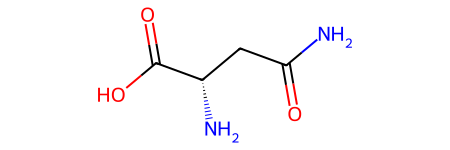

In [133]:
query_id = 8
query_mols[query_id]

In [140]:
analogue_id = 0
get_query_analogues_smiles(query_id=query_id, analogues_df=n_analogues)

['CC(=O)N1CCC[C@H]1C(=O)O',
 'NCC(=O)N(C1)C(CC1)C(O)=O',
 'CCC(=O)N1CCCC1C(=O)O',
 'NCC(=O)NCC(=O)N1CCC[C@H]1C(=O)O',
 'CC(O)=N[C@@H](CC(=O)O)C(=O)O']

In [254]:
benchmark_results[6][benchmark_results[6]["query_mass"].between(0, 5)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   query_id               0 non-null      int64  
 1   query_weight_diff      0 non-null      float64
 2   analogue_weight_diffs  0 non-null      object 
 3   stacked_weights        0 non-null      object 
 4   isf_scores             0 non-null      object 
 5   isf_mean               0 non-null      float64
 6   distances              0 non-null      object 
 7   distances_mean         0 non-null      float64
 8   query_size             0 non-null      int64  
 9   query_mass             0 non-null      float64
 10  analogue_sizes         0 non-null      object 
 11  mean_analogue_size     0 non-null      float64
 12  analogue_masses        0 non-null      object 
 13  mean_analogue_mass     0 non-null      float64
 14  time                   0 non-null      float64
dtypes: float64(7), int64(2)

# Benchmark

In [141]:
# code taken from https://github.com/florian-huber/molecular_fingerprint_comparisons
@numba.njit
def ruzicka_similarity(A, B):
    """
    Calculate the Ruzicka similarity between two count vectors.
    
    Parameters:
    A (array-like): First count vector.
    B (array-like): Second count vector.
    
    Returns:
    float: Ruzicka similarity.
    """
    
    min_sum = np.sum(np.minimum(A, B))
    max_sum = np.sum(np.maximum(A, B))
    
    return min_sum / max_sum


@numba.jit(nopython=True, fastmath=True, parallel=True)
def ruzicka_similarity_matrix(references: np.ndarray, queries: np.ndarray) -> np.ndarray:
    """Returns matrix of Ruzicka similarity between all-vs-all vectors of references and queries.

    Parameters
    ----------
    references
        Reference vectors as 2D numpy array. Expects that vector_i corresponds to
        references[i, :].
    queries
        Query vectors as 2D numpy array. Expects that vector_i corresponds to
        queries[i, :].

    Returns
    -------
    scores
        Matrix of all-vs-all similarity scores. scores[i, j] will contain the score
        between the vectors references[i, :] and queries[j, :].
    """
    assert references.shape[1] == queries.shape[1], "Vector sizes do not match!"

    size1 = references.shape[0]
    size2 = queries.shape[0]
    scores = np.zeros((size1, size2)) #, dtype=np.float32)
    for i in prange(size1):
        for j in range(size2):
            scores[i, j] = ruzicka_similarity(references[i, :], queries[j, :])
    return scores

NameError: name 'numba' is not defined

In [ ]:
def off_diagonal_mean(matrix):
    n = matrix.shape[0]
    # Create mask for off-diagonal elements
    mask = ~np.eye(n, dtype=bool)
    return matrix[mask].mean()

def str_to_list_of_ints(series):
    return [int(x) for x in series.strip("[]").split(",") if x.strip().isdigit()]

def get_group_sized_benchmark_df_file(df_file, query_mols, n_analogues, morgan_radius, fpSize, group_size):
    try:
        analogue_df = pd.read_csv(df_file, index_col=0)
        analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)
        print(f"Found {df_file}\nTrying to access benchmark columns.\nExisting columns: {analogue_df.columns.tolist()}")
        query_smiles= analogue_df[:1].query_smiles
        query_sim= analogue_df[:1].query_sim
        query_sims=analogue_df[:1].query_sims
        query_mean_weights=analogue_df[:1].query_mean_weights
        group_smiles=analogue_df[:1].group_smiles
        group_sim=analogue_df[:1].group_sim
        sgs=analogue_df[:1].sgs
        sgs_score=analogue_df[:1].sgs_score
        sgs_scores=analogue_df[:1].sgs_scores
        isf_score=analogue_df[:1].isf_score
        isf_scores=analogue_df[:1].isf_scores
        distance=analogue_df[:1].distance
        distances=analogue_df[:1].distances
        print(f"Benchmark found! Loaded benchmark for {len(analogue_df)} queries.")
    except Exception as e:
        print(f"Benchmark not found: {df_file}\nRunning the benchmark dataframe generation.")
        # generate benchmark dataframe
        simmap_fp_function = FingerprintFunction(fingerprint="MORGAN")
        simmap_fp_function.fp_type = "count"
        simmap_fp_function.morgan_radius = morgan_radius
        simmap_fp_function.nbits = fpSize
        
        n_analogues = analogue_search(explorer=explorer, n=group_size)
        n_analogues = generate_analogue_mols(n_analogues, n=group_size)
        
        fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=FINGERPRINT_BITS)

        for query_id, query in tqdm(enumerate(query_mols), desc="Processing queries"):
            analogues = get_query_analogues(query_id=query_id, analogues_df=n_analogues)
            
            query_fp = fpgen.GetCountFingerprint(query)
            analogue_fps = [fpgen.GetCountFingerprint(mol) for mol in analogues]
            analogue_fps_numpy = np.empty((len(analogues), FINGERPRINT_BITS), dtype=np.int8)
            query_sims = DataStructs.BulkTanimotoSimilarity(query_fp, analogue_fps)
            
            stacked_mean_weights = []
            query_mean_weights = []
            query_scaled_inverted_differnces = []
            for i, ref_analogue in enumerate(analogues):
                DataStructs.ConvertToNumpyArray(analogue_fps[i], analogue_fps_numpy[i])
                
                # create array for stacked weights
                stacked_atomic_weights = [0] * ref_analogue.GetNumAtoms()
                
                # compute the group similarity map weights
                for j, probe_analogue in enumerate(analogues):#tqdm(analogue_ids, desc=f"Computing weights for weights for analogue {ref_id}", leave=False):
                    if i == j:
                        continue

                    # extract and standardize similarity weights for the reference molecule
                    ref_sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(probe_analogue, ref_analogue, simmap_fp_function.get_function, metric=DataStructs.TanimotoSimilarity) #this is the bottle neck
                    #print(f"Getting weights took {(pd.Timestamp.now() - getting_weights_start).total_seconds():.4f} seconds")

                    # stack the weights
                    stacked_atomic_weights = [stacked_atomic_weights[i] + ref_sim_weights[i] for i in range(ref_analogue.GetNumAtoms())]
                # Standardize the stacked weights
                stacked_atomic_weights, _ = SimilarityMaps.GetStandardizedWeights(stacked_atomic_weights)
                stacked_mean_weights.append(sum(stacked_atomic_weights) / len(stacked_atomic_weights))
                
                # compute the similarity map weights against the query molecule
                query_atomic_weights = get_similarity_map_weights(ref_analogue, query, simmap_fp_function)
                query_mean_weights.append(sum(query_atomic_weights) / len(query_atomic_weights))
                
                # calculate absolute weight difference for each atom against the query
                query_abs_differences = ([abs(stacked_atomic_weights[i] - query_atomic_weights[i]) for i in range(len(stacked_atomic_weights))])
                query_mean_difference = sum(query_abs_differences) / len(query_abs_differences)
                
                # scale and invert the mean absolute difference to get a similarity score
                query_scaled_inverted_differnce = 1 - (query_mean_difference * 0.5)
                query_scaled_inverted_differnces.append(query_scaled_inverted_differnce)
            
            # --- gather results ---
            
            # smiles
            analogue_df.loc[query_id, "group_smiles"] = get_query_analogues_smiles(query_id=query_id, analogues_df=n_analogues)
            analogue_df.loc[query_id, "query_smiles"] = query_spectra[query_id].metadata["smiles"]
            
            # all query sims
            analogue_df.loc[query_id, "query_sims"] = query_sims
            # mean ruzicka similarity of analogue vs query ruzicka similaities
            analogue_df.loc[query_id, "query_sim"] = np.mean(query_sims)
            
            #  mean of the means of query atomic weights
            unscaled_query_mean_weights = np.mean(query_mean_weights)  # range [-1, 1]
            analogue_df.loc[query_id, "query_mean_weights"] = (unscaled_query_mean_weights + 1) / 2   # range [0, 1]
            
            # mean of all-vs-all analogue ruzicka similarities
            fp_group_sim_matrix = ruzicka_similarity_matrix(analogue_fps_numpy, analogue_fps_numpy)
            group_sim = off_diagonal_mean(fp_group_sim_matrix)
            analogue_df.loc[query_id, "group_sim"] = group_sim
            
            # mean of the means of stacked atomic weights of all-vs-all analogue similarity maps
            unscaled_sgs = np.mean(stacked_mean_weights)                # range [-1, 1]
            analogue_df.loc[query_id, "sgs"] = (unscaled_sgs + 1) / 2   # range [0, 1]
            
            # all SQS
            analogue_df.loc[query_id, "sgs_scores"] = query_scaled_inverted_differnces
            # scaled and inverted mean of the means of the absolute differences between atomic stacked weights and atomic query weights
            sgs_score = (sum(query_scaled_inverted_differnces) / len(query_scaled_inverted_differnces))
            analogue_df.loc[query_id, "sgs_score"] = sgs_score
            
            # ISF
            isf_scores = get_query_analogues_isf(query_id=query_id, analogues_df=n_analogues)
            analogue_df.loc[query_id, "isf_scores"] = isf_scores
            analogue_df.loc[query_id, "isf_score"] = np.mean(isf_scores)
            
            # distance
            distances = get_query_analogues_distance(query_id=query_id, analogues_df=n_analogues)
            analogue_df.loc[query_id, "distances"] = distances
            analogue_df.loc[query_id, "distance"] = np.mean(distances)

        analogue_df.to_csv(df_file)
        print(f"Saved {len(analogue_df)} queries to {df_file}.")
    return analogue_df

In [ ]:
max_group_size = GROUP_SIZE + 1
all_dfs = []

for group_size in tqdm(range(2, max_group_size), desc="Benchmarking varying group sizes..."):
    group_sized_df_file = os.path.join("data", "explorer_group_size", f"explorer_benchmark_size{group_size}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")
    n_analogues = analogue_search(explorer=explorer, n=group_size)
    n_analogues = generate_analogue_mols(n_analogues, n=group_size)
    analogue_df = get_group_sized_benchmark_df_file(group_sized_df_file, query_mols, n_analogues, MORGAN_RADIUS, FINGERPRINT_BITS, group_size)
    analogue_df["group_sim_diff"] = abs(analogue_df.sgs - analogue_df.group_sim)
    print(f"-------- Group size {group_size}: Entries with group_sim_diff greater than 0.05 = {len(analogue_df[analogue_df.group_sim_diff > 0.05])} --------")
    all_dfs.append(analogue_df)